In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# df = pd.read_csv('seq_with_dis.csv')
# df = df.reset_index(drop=True)
# disColnames = [" dis " + str(i) for i in range(0, 64)]
# y_data = df[disColnames]
# # df
# y_data.max().values

In [4]:
file_path = 'seq_with_dis.csv'
output_model_path = 'model/cvae_model.pt'
output_images_path = 'images'
output_npz_path = 'results'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

def ensure_directory_exists(path):
    """Ensure directory exists; if not, create it."""
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

# Ensure directories for model, logs, and images exist
ensure_directory_exists(os.path.dirname(output_model_path))
ensure_directory_exists(output_images_path)
ensure_directory_exists(output_npz_path)

# Dataset
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

def oneHotter(seqs):
    charToInt = {"A": 0, "C": 1, "G": 2, "T": 3}
    return [charToInt[let] for let in seqs]

def load_data_set_seq2seq(file_path, batch_size_=16, split=.2, ynormfac=22., verbose=False):
    df = pd.read_csv(file_path)
    df = df.reset_index(drop=True)

    seqs = df.Sequence.values
    lengths = [len(s) for s in seqs]

    min_length_measured = min(lengths)
    max_length_measured = max(lengths)

    condLen = 64
    disColnames = [" dis " + str(i) for i in range(0, condLen)]

    # y_data = np.array(df[disColnames])
    y_data = df[disColnames]
    # y_data = y_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    # y_data = y_data.apply(lambda x: (x) / (x.max()))
    y_data = np.array(y_data)
    y_data = y_data/y_data.max(axis=1)[:,None]
    print(" ********    dddd    ", np.max(y_data.max(axis=1)))
    ##
    X = np.array(df.Sequence.apply(oneHotter).tolist())

    print(f"X shape: {X.shape}")
    print(f"y_data shape: {y_data.shape}")

    X_train, X_val, y_train, y_val = train_test_split(X, y_data, test_size=split)#, random_state=235)

    train_dataset = RegressionDataset(torch.from_numpy(X_train).float(),
                                      torch.from_numpy(y_train).float() / ynormfac)

    val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float() / ynormfac)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_)

    return train_loader, val_loader

# Model Base Class
class Model(nn.Module):
    def __init__(self, filepath=None):
        super(Model, self).__init__()
        self.filepath = filepath or 'default_model.pt'
        self.trainer_config = ''

    def forward(self, x):
        raise NotImplementedError

    def __repr__(self):
        raise NotImplementedError

    def update_filepath(self):
        if not self.filepath:
            raise ValueError("Filepath not initialized")
        cur_dir = os.getcwd()
        self.filepath = os.path.join(cur_dir, 'models', self.__repr__(), self.__repr__() + '.pt')

    def update_trainer_config(self, config):
        self.trainer_config = config
        self.update_filepath()

    def save(self, hidden_size, emb_dim, dropout):
        save_dir = os.path.dirname(self.filepath)
        ensure_directory_exists(save_dir)
        # torch.save(self.state_dict(), self.filepath)
        torch.save({
            'hidden_size': hidden_size,
            'emb_dim': emb_dim,
            'dropout': dropout,
            'model_state_dict': self.state_dict()
            }, self.filepath)
        print(f'Model {self.__repr__()} saved')

    def save_checkpoint(self, epoch_num):
        filename = os.path.join(os.path.dirname(self.filepath), self.__repr__() + '_' + str(epoch_num) + '.pt')
        ensure_directory_exists(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)

    def load(self, state_dict=None, cpu=False):
        if state_dict:
            self.load_state_dict(state_dict)
        else:
            if cpu:
                self.load_state_dict(torch.load(self.filepath, map_location=lambda storage, loc: storage))
            else:
                # self.load_state_dict(torch.load(self.filepath))
                self.load_state_dict(torch.load(self.filepath))

    def xavier_initialization(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)

# Conditional VAE Model
class ConditionalSequenceModel(Model):
    ALPHABET = ['A', 'C', 'G', 'T']

    def __init__(self, n_chars=4, seq_len=10, cond_size=64, bidirectional=True, batch_size=32, hidden_layers=1, hidden_size=32, lin_dim=16, emb_dim=10, dropout=0.1):
        super(ConditionalSequenceModel, self).__init__(output_model_path)
        self.n_chars = n_chars
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.emb_dim = emb_dim
        self.dropout = dropout
        self.lin_dim = lin_dim
        self.batch_size = batch_size
        self.cond_size = cond_size
        self.beta = 0.002
        self.capacity = 0.0

        # self.emb_lstm = nn.LSTM(input_size=n_chars + cond_size, hidden_size=hidden_size, num_layers=hidden_layers, batch_first=True, dropout=dropout if hidden_layers > 1 else 0, bidirectional=bidirectional)
        self.emb_lstm = nn.LSTM(input_size=n_chars, hidden_size=hidden_size, num_layers=hidden_layers, batch_first=True, dropout=dropout if hidden_layers > 1 else 0, bidirectional=bidirectional)
        # self.emb_lstm = nn.LSTM(input_size=n_chars, hidden_size=hidden_size, num_layers=hidden_layers, batch_first=True, dropout=0, bidirectional=bidirectional)
        self.latent_linear = nn.Sequential(
            nn.Linear(hidden_size * seq_len * 2 + cond_size, lin_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        self.latent_mean = nn.Linear(lin_dim, emb_dim)
        self.latent_log_std = nn.Linear(lin_dim, emb_dim)
        # self.latent_mean = nn.Sequential(nn.Linear(lin_dim, emb_dim), nn.Tanh())
        # self.latent_log_std = nn.Sequential(nn.Linear(lin_dim, emb_dim), nn.Tanh())
        self.dec_lin = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            # nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        self.dec_lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, num_layers=hidden_layers, dropout=dropout if hidden_layers > 1 else 0, batch_first=True, bidirectional=bidirectional)
        # self.dec_lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size, num_layers=hidden_layers, dropout=0, batch_first=True, bidirectional=bidirectional)
        self.dec_final = nn.Linear(hidden_size * seq_len * 2 + cond_size, n_chars * seq_len)

        self.xavier_initialization()

    def encode(self, x, c):
        # print("encoder c   ", c)
        x_one_hot = x.float().unsqueeze(2)
        x_one_hot = torch.nn.functional.one_hot(x_one_hot.long(), num_classes=self.n_chars).float()
        x_one_hot = x_one_hot.squeeze(2)
        # print("x   ", x_one_hot.shape)
        # print("c 1    ", c.shape)
        # c = c.unsqueeze(1).repeat(1, x.size(1), 1)
        # c = torch.zeros(c.shape).to(device)
        # print("c 2    ", c.shape)
        # xc = torch.cat((x_one_hot, c), dim=-1)
        # print("xc    ", xc.shape)
        # xc = x_one_hot
        hidden, _ = self.emb_lstm(x_one_hot)
        hidden = torch.flatten(hidden, 1)
        # print("hidden    ", hidden.shape)
        # print("c    ", c.shape)
        # print("hidden    ", hidden)
        # print("c    ", c[0,:])
        # print("c    ", c[1,:])
        # print("c    ", c[2,:])
        # c = torch.zeros(c.shape).to(device)
        hidden = torch.cat((hidden, c), dim=-1)
        hidden = self.latent_linear(hidden)
        
        z_mean = self.latent_mean(hidden)
        z_log_std = self.latent_log_std(hidden)
        # print("mean   ", z_mean)
        # print("std    ", z_log_std)
        return torch.distributions.Normal(loc=z_mean, scale=torch.exp(z_log_std)), z_mean, z_log_std

    def decode(self, z, c):
        # c = torch.zeros(c.shape).to(device)
        # print("dedcode   ")
        # print("z   ", z.shape)
        # print("c   ", c.shape)
        # zc = torch.cat((z, c), dim=1)
        # zc = z
        hidden = self.dec_lin(z)
        hidden = hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        hidden, _ = self.dec_lstm(hidden)
        conc = torch.cat((torch.flatten(hidden, 1), c), dim=1)
        out = self.dec_final(conc)
        return out.view(-1, self.seq_len, self.n_chars)

    def forward(self, x, c):
        dist, z_mean, z_log_std = self.encode(x, c)
        # z = dist.rsample()
        z, prior_sample, prior = self.reparametrize(dist)
        dec = self.decode(z, c)
        return dec, z_mean, z_log_std

    def generate(self, c, nz=50):
        num = c.shape[0]
        z = torch.randn([num, nz]).to(device)
        rec_x = self.decode(z, c=c)
        return rec_x
        # pass
    
    
    def reparametrize(self, dist):
        sample = dist.rsample()
        prior = torch.distributions.Normal(torch.zeros_like(dist.loc), torch.ones_like(dist.scale))
        prior_sample = prior.sample()
        return sample, prior_sample, prior


    def __repr__(self):
        return "ConditionalSequenceModel"

    @staticmethod
    def mean_crossentropy_loss(weights, targets):
        criteria = nn.CrossEntropyLoss(reduction='mean')
        batch_size, seq_len, num_notes = weights.size()
        assert (batch_size == targets.size(0))
        assert (seq_len == targets.size(1))
        weights = weights.view(-1, num_notes)
        targets = targets.view(-1)
        loss = criteria(weights, targets.long())
        return loss

    @staticmethod
    def mean_accuracy(weights, targets):
        _, max_indices = weights.max(2)
        targets = targets.argmax(dim=2) if targets.dim() > 2 else targets
        correct = max_indices == targets
        # print("weights    ", weights.shape)
        # print("max_indices    ", max_indices.shape)
        # print("targets    ", targets.shape)
        # print("numel    ", targets.numel())
        return torch.sum(correct.float()) / targets.numel()

    @staticmethod
    def reconstruction_loss(x, x_recons):
        return ConditionalSequenceModel.mean_crossentropy_loss(weights=x_recons, targets=x)

    @staticmethod
    def kld_gaussian(mu, log_std):
        return -0.5 * torch.sum(1 + log_std - mu.pow(2) - log_std.exp(), dim=1)

    def total_loss(self, x, c, recons, dist, mu, log_std):
        recons_loss = self.reconstruction_loss(x, recons)
        kld_loss = torch.mean(self.kld_gaussian(mu, log_std))
        return recons_loss + self.beta * torch.abs(kld_loss - self.capacity)#, recons_loss, kld_loss

# Define the trainer function
def train(model, num_epochs, learning_rate, train_loader, val_loader, output_model_path):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay for L2 regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.8, verbose=True)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')  # Initialize best validation loss for early stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # running_accuracy = 0.0
        running_accuracy = []
        for X_batch, y_batch in train_loader:
            # print("xbatch   ", X_batch)
            # print("ybatch   ", y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            # outputs, _ = model(X_batch, y_batch)
            outputs, z_mean, z_log_std = model(X_batch, y_batch)
            # loss = criterion(outputs.view(-1, model.n_chars), X_batch.view(-1).long())
            # loss = model.mean_crossentropy_loss(outputs, X_batch.long())
            loss = model.total_loss(X_batch.long(), None, outputs, None, z_mean, z_log_std)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy = ConditionalSequenceModel.mean_accuracy(outputs, X_batch)
            # running_accuracy += accuracy.item()
            running_accuracy.append(accuracy.item())

        epoch_loss = running_loss / len(train_loader)
        # epoch_accuracy = running_accuracy / len(train_loader)
        epoch_accuracy = np.mean(running_accuracy)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # print("X batch    ", X_batch)
        # print("train out   ", outputs.argmax(axis=-1))
        # print("train acc    ", accuracy)
        print("len    ", len(running_accuracy))
        print("train acc final   ", epoch_accuracy)


        model.eval()
        val_loss = 0.0
        # val_accuracy = 0.0
        val_accuracy = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs, z_mean, z_log_std = model(X_val, y_val)
                # loss = criterion(outputs.view(-1, model.n_chars), X_val.view(-1).long())
                loss = model.total_loss(X_val.long(), None, outputs, None, z_mean, z_log_std)
                val_loss += loss.item()
                accuracy = ConditionalSequenceModel.mean_accuracy(outputs, X_val)
                # val_accuracy += accuracy.item()
                val_accuracy.append(accuracy.item())

        epoch_val_loss = val_loss / len(val_loader)
        # epoch_val_accuracy = val_accuracy / len(val_loader)
        epoch_val_accuracy = np.mean(val_accuracy)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # print("X val    ", X_val)
        # print("val out   ", outputs.argmax(axis=-1))
        # print("val acc    ", accuracy)
        print("len    ", len(val_accuracy))
        print("val acc final   ", epoch_val_accuracy)

        # Step the scheduler
        scheduler.step(epoch_val_loss)

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            # torch.save(model.state_dict(), output_model_path)
            model.save(model.hidden_size, model.emb_dim, model.dropout)
            print(f"Model saved to {output_model_path} at epoch {epoch+1}")

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


Training with batch_size=32, latent_size=30, learning_rate=0.001, hidden_size=6, condition_size=64, beta=0.007
 ********    dddd     1.0
X shape: (2098, 10)
y_data shape: (2098, 64)


c:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


len     53
train acc final    0.31887634801414777
len     14
val acc final    0.37098214456013273
Model ConditionalSequenceModel saved
Model saved to model/cvae_model.pt at epoch 1
Epoch 1/200, Train Loss: 1.3672, Validation Loss: 1.3203, Train Accuracy: 0.3189, Validation Accuracy: 0.3710
len     53
train acc final    0.35937500112461596
len     14
val acc final    0.38727678784302305
Model ConditionalSequenceModel saved
Model saved to model/cvae_model.pt at epoch 2
Epoch 2/200, Train Loss: 1.3171, Validation Loss: 1.3036, Train Accuracy: 0.3594, Validation Accuracy: 0.3873
len     53
train acc final    0.3698281685136399
len     14
val acc final    0.38370536054883686
Model ConditionalSequenceModel saved
Model saved to model/cvae_model.pt at epoch 3
Epoch 3/200, Train Loss: 1.3076, Validation Loss: 1.3005, Train Accuracy: 0.3698, Validation Accuracy: 0.3837
len     53
train acc final    0.3742924501311104
len     14
val acc final    0.38258928273405346
Model ConditionalSequenceModel 

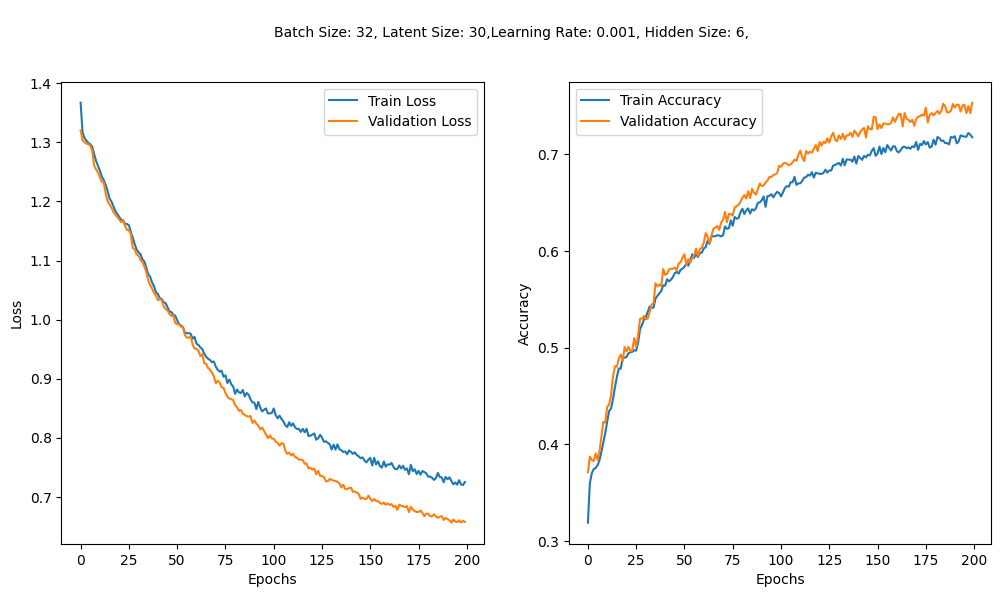

In [5]:
### more more embed_dim
# Define a grid of hyperparameters
batch_sizes = [32]
latent_sizes = [30]
learning_rates = [0.001]
hidden_sizes = [6]
condition_sizes = [64]
betas = [0.007]

epochs = 200
input_size = 4
output_size = 40
split_ratio = 0.2
ynormfac = 1.0
seq_len = 10

best_val_loss = float('inf')
best_hyperparams = None

for batch_size in batch_sizes:
    for latent_size in latent_sizes:
        for learning_rate in learning_rates:
            for hidden_size in hidden_sizes:
                for condition_size in condition_sizes:
                    for beta in betas:
                        print(f"Training with batch_size={batch_size}, latent_size={latent_size}, learning_rate={learning_rate}, hidden_size={hidden_size}, condition_size={condition_size}, beta={beta}")
                        train_loader, val_loader = load_data_set_seq2seq(file_path, batch_size_=batch_size, split=split_ratio, ynormfac=ynormfac)

                        emb_dim = 50
                        dropout = 0.1
                        model = ConditionalSequenceModel(n_chars=input_size, seq_len=seq_len, cond_size=condition_size, hidden_size=hidden_size, emb_dim=emb_dim, dropout=dropout)
                        model.beta = beta
                        model.to(device)

                        train_losses, val_losses, train_accuracies, val_accuracies = train(
                            model, num_epochs=epochs, learning_rate=learning_rate,
                            train_loader=train_loader, val_loader=val_loader,
                            output_model_path=output_model_path
                        )
                        hyperparams_str = (
                            f"\n"
                            f"Batch Size: {batch_size}, Latent Size: {latent_size},Learning Rate: {learning_rate}, Hidden Size: {hidden_size},\n"
                        
                        )
                        plt.figure(figsize=(12, 6))
                        plt.subplot(1, 2, 1)
                        plt.plot(train_losses, label='Train Loss')
                        plt.plot(val_losses, label='Validation Loss')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss')
                        plt.legend()

                        plt.subplot(1, 2, 2)
                        plt.plot(train_accuracies, label='Train Accuracy')
                        plt.plot(val_accuracies, label='Validation Accuracy')
                        plt.xlabel('Epochs')
                        plt.ylabel('Accuracy')
                        plt.suptitle(hyperparams_str, fontsize=10, y=1)
                        plt.legend()
                        plt.savefig(os.path.join(output_images_path, f'accuracies_latent{latent_size}_hidden{hidden_size}_lr{learning_rate}_beta{beta}.png'))
                        plt.show()
                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            best_hyperparams = (batch_size, latent_size, learning_rate, hidden_size, condition_size, beta)

In [6]:
### load model
def load_checkpoint(model_path):
    checkpoint = torch.load(model_path)
    # print(checkpoint)
    hidden_size = checkpoint['hidden_size']
    emb_dim = checkpoint['emb_dim']
    dpout = checkpoint['dropout']
    model = ConditionalSequenceModel(n_chars=input_size, seq_len=seq_len, cond_size=condition_size, hidden_size=hidden_size, emb_dim=emb_dim, dropout=dpout)
    model.load(checkpoint['model_state_dict'])
    model = model.to(device)
    return model

In [9]:
input_size = 4
seq_len = 10
condition_size = 64
# load_path = output_model_path
# load_path = 'model/cvae_model_backup_1.pt'
load_path = 'model/cvae_model.pt'
model = load_checkpoint(load_path)

In [11]:
def revOneHotter(seqs):
    intToChar = {0: "A", 1: "C", 2: "G", 3: "T"}
    ret = [[intToChar[let] for let in seq] for seq in seqs]
    return np.array(ret)
def sample_cvae(conditions):
    rec = model.generate(conditions)
    # print(rec.shape)
    labels = torch.argmax(rec, 2)
    # print(labels.shape)
    labels = labels.detach().numpy().tolist()
    ret = revOneHotter(labels)
    # print("shape   ", ret.shape)
    # print(ret)
    return ret

# sampels = sample_cvae(c)

def remove_duplicates(org, seq):
    # print("org   ", org)
    ret = []
    for i in range(len(seq)):
        if seq[i] not in org:
            ret.append(seq[i])
    ret = list(set(ret))
    return ret

def sample(num):#, cls):
    # df2 = df[df['Label'] == cls]
    df = pd.read_csv("seq_with_dis.csv")
    df = df[df['Peak NIR WAV'].notnull()]
    disColnames = [" dis " + str(i) for i in range(0, condition_size)]
    y_data = df[disColnames]
    y_data = np.array(y_data)
    y_data = y_data/y_data.max(axis=1)[:,None]
    ret = []
    for i in range(num):
        rint = np.random.randint(len(y_data))
        ret.append(y_data[rint,:])
    ret = np.array(ret)
    ret = torch.from_numpy(ret).float()
    # print("ret    ", ret.shape)
    generated_samples = sample_cvae(ret)
    # print("samples    ", generated_samples.shape)
    # print("samples    ", type(generated_samples))
    gen_seq = [''.join(row) for row in generated_samples]
    # print("seq    ", gen_seq)
    filtered_seq = remove_duplicates(df['Sequence'].values, gen_seq)
    return filtered_seq

generated_samples = sample(10000)
print("generated samples    ", generated_samples)
print("length    ", len(generated_samples))

generated samples     ['GCCACCAATG', 'CCGCGAGAGA', 'ACCCCCGCTT', 'GTGGGGAGAA', 'ACGAGGAGGA', 'CCACATCAGG', 'ATTACCTCTA', 'GGCGGCAGCC', 'TCTAAGGCCA', 'ACCCGACGCG', 'GAAAGGGATA', 'GGACACCACT', 'CCACGGGAGG', 'CGGCCGAATG', 'CTTCCCCGTT', 'GCTCGGCCTT', 'GACCGGGTTC', 'GAACATACTG', 'GACAGAGGCC', 'GGGAAGACCT', 'GGAGGCGAGG', 'GAGCCCCGTA', 'ATCCCAGAGC', 'ATCACCCGAC', 'GGAAGAGAGG', 'CTAGGGCGTG', 'AGCGGAAGAA', 'GGACCGAATC', 'CATGCTGGAC', 'AAAAGGCCTA', 'CCCGCCATTT', 'CGCTGGGCTC', 'TTAGCCGTGA', 'CGGGTCCTCA', 'CTGACGACCT', 'GCGCCCAGTG', 'GCGCCGGGCC', 'CCCCAGACCC', 'GCGAGGACCA', 'AGAACCCTTC', 'TGAAACCTGA', 'AACCCCCATC', 'CCGCGCGATT', 'TTGGCCCTAC', 'GTCTGAATCT', 'GGACACGAGT', 'AAGCCTACGG', 'GAGCCCCCGA', 'CCCACGACCT', 'TCTCACCACA', 'GAAGCTACAT', 'ATAGCCACGG', 'AAACCCCACA', 'CCCGGAAATT', 'GGGAAGACTT', 'AGCCGAAGGG', 'AGTAACTGGA', 'CCCCGACATT', 'CCCTACCGGC', 'CTATGCGCGA', 'GATGCAACTG', 'CTGCCACAAA', 'CCGACGCGCC', 'AACCCGCTAC', 'GGGAATACTC', 'GATCCAGAAA', 'GTAACGCCTC', 'CGTCGCGGAA', 'CACAAGACTA', 'ACCTAGCAGA

In [ ]:

def revOneHotter(seqs):
    intToChar = {0: "A", 1: "C", 2: "G", 3: "T"}
    ret = [[intToChar[let] for let in seq] for seq in seqs]
    return np.array(ret)
def sample_cvae(conditions):
    rec = model.generate(conditions)
    # print(rec.shape)
    labels = torch.argmax(rec, 2)
    # print(labels.shape)
    labels = labels.detach().numpy().tolist()
    ret = revOneHotter(labels)
    # print("shape   ", ret.shape)
    # print(ret)
    return ret

# sampels = sample_cvae(c)

def remove_duplicates(org, seq):
    # print("org   ", org)
    ret = []
    for i in range(len(seq)):
        if seq[i] not in org:
            ret.append(seq[i])
    ret = list(set(ret))
    return ret

def sample(num):#, cls):
    # df2 = df[df['Label'] == cls]
    df0 = pd.read_csv("seq_with_dis.csv")
    df = pd.read_csv("seq_with_dis.csv")
    df = df[df['Peak NIR WAV'].notnull()]
    disColnames = [" dis " + str(i) for i in range(0, condition_size)]
    y_data = df[disColnames]
    y_data = np.array(y_data)
    y_data = y_data/y_data.max(axis=1)[:,None]
    ret = []
    for i in range(num):
        rint = np.random.randint(len(y_data))
        ret.append(y_data[rint,:])
    ret = np.array(ret)
    ret = torch.from_numpy(ret).float()
    # print("ret    ", ret.shape)
    generated_samples = sample_cvae(ret)
    # print("samples    ", generated_samples.shape)
    # print("samples    ", type(generated_samples))
    gen_seq = [''.join(row) for row in generated_samples]
    # print("seq    ", gen_seq)
    filtered_seq = remove_duplicates(df0['Sequence'].values, gen_seq)
    return filtered_seq

generated_samples = sample(10000)
print("generated samples    ", generated_samples)
print("length    ", len(generated_samples))
generated_samples_df = pd.DataFrame(generated_samples, columns=["Sequence"])
generated_samples_df.to_csv("generated_samples.csv", index=False)